In [1]:
# dataset link
#https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix,average_precision_score,fbeta_score,roc_curve,auc,classification_report
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df=pd.read_csv('creditcard.csv')

## EDA

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
#total number of records
n_records = len(df)

# total number of fraud items
n_fraud = len(df[df['Class'] == 1])

# total number of normal transactions
n_normal = len(df[df['Class'] == 0])

# percentage of fraud transactions
fraud_percent = n_fraud * 100.0 / n_records

# Print the results
print ("Total number of records: {}".format(n_records))
print ("Number of Fraud transaction: {}".format(n_fraud))
print ("Number of Normal transaction: {}".format(n_normal))
print ("Percentage of fraud transacation: {:.2f}%".format(fraud_percent))

Total number of records: 284807
Number of Fraud transaction: 492
Number of Normal transaction: 284315
Percentage of fraud transacation: 0.17%


In [8]:
#looking at the dataset it is clear that dataset is highly unbalanced as only 0.17% data is fraud

In [9]:
x_trn,x_test,y_trn,y_test=train_test_split(df.drop(columns="Class"),df["Class"]) # test set for final evalaution
x_train,x_val,y_train,y_val=train_test_split(x_trn,y_trn)

In [10]:
y_trn.sum()/len(y_trn) #percentage of fraud detection

0.0017181245757355867

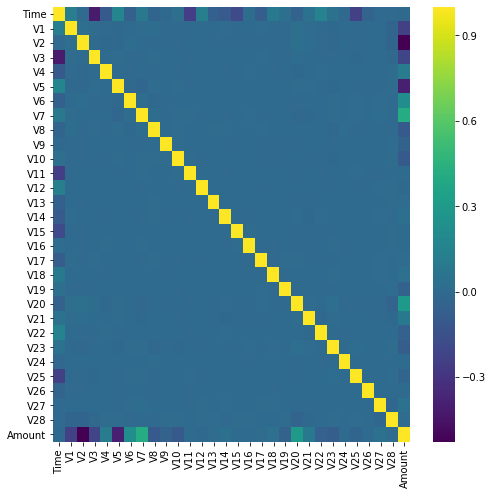

In [11]:
plt.figure(figsize=(8,8))
sns.heatmap(x_train.corr(),cmap='viridis')

In [12]:
#very low correlation among fetures looks like PCA has been done and original feature has been masked

Text(0.5, 1.0, 'Distribution of Amount for Fraud Class')

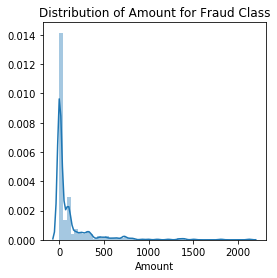

In [13]:
plt.figure(figsize=(4,4))
sns.distplot(df["Amount"][df["Class"]==1])
plt.title('Distribution of Amount for Fraud Class')

Text(0.5, 1.0, 'Distribution of Amount for Normal Class')

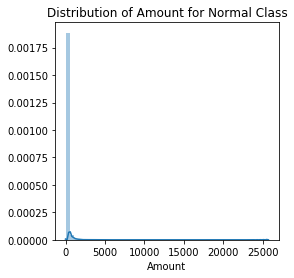

In [14]:
plt.figure(figsize=(4,4))
sns.distplot(df[df['Class']==0]['Amount'])
plt.title('Distribution of Amount for Normal Class')

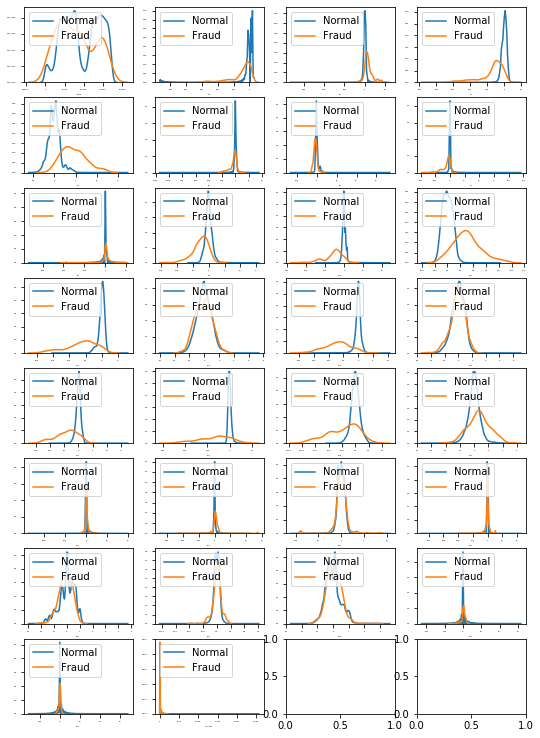

In [15]:
plt.subplots(8,4,figsize=(9,13))
df_normal=df[df["Class"]==0]
df_fraud=df[df["Class"]==1]
i=0
for var in x_trn.columns:
    i=i+1
    plt.subplot(8,4,i)
    sns.kdeplot(df_normal[var],label="Normal")
    sns.kdeplot(df_fraud[var],label="Fraud")
    plt.xlabel(var, fontsize=2)
    plt.legend(loc='upper left')
    plt.tick_params(axis='both', which='major', labelsize=2)
plt.show()

In [16]:
#Anderson Darling test of Normality
from scipy.stats import anderson
df_normal=df[df["Class"]==0]
df_fraud=df[df["Class"]==1]
for var in x_trn.columns:
    statistic,critical_values,_=anderson(df_normal[var],dist='norm')
    if statistic>critical_values[1]:
        print('{} of Normal Transaction is not following normal distribution at 10 percent level significance'.format(var))
    else:
        print('{} of Normal is following normal distribution at 10 percent level significance'.format(var))
    statistic,critical_values,_=anderson(df_fraud[var])
    if statistic>critical_values[1]:
        print('{} of Fraud Transaction is not following normal distribution at 10 percent level significance'.format(var))
    else:
        print('{} of Fraud is following normal distribution at 10 percent level significance'.format(var))

Time of Normal Transaction is not following normal distribution at 10 percent level significance
Time of Fraud Transaction is not following normal distribution at 10 percent level significance
V1 of Normal Transaction is not following normal distribution at 10 percent level significance
V1 of Fraud Transaction is not following normal distribution at 10 percent level significance
V2 of Normal Transaction is not following normal distribution at 10 percent level significance
V2 of Fraud Transaction is not following normal distribution at 10 percent level significance
V3 of Normal Transaction is not following normal distribution at 10 percent level significance
V3 of Fraud Transaction is not following normal distribution at 10 percent level significance
V4 of Normal Transaction is not following normal distribution at 10 percent level significance
V4 of Fraud Transaction is not following normal distribution at 10 percent level significance
V5 of Normal Transaction is not following normal di

In [17]:
# Though variables are not following  Normal Distribution , we will use parametric Hypothesis testing of difference of mean 
df_normal=df[df["Class"]==0]
l_normal=len(df_normal)
df_fraud=df[df["Class"]==1]
l_fraud=len(df_fraud)
for var in df.drop(columns=["Time","Class"]).columns:
    mean_normal=df_normal[var].mean()
    var_normal=df_normal[var].var()
    mean_fraud=df_fraud[var].mean()
    var_fraud=df_fraud[var].var()
    h=(mean_normal-mean_fraud)/np.sqrt((var_normal/l_normal) + (var_fraud/l_fraud))
    if (h>2.58 or h<-2.58):
        print("varibale {} is significant at 10 percent significance.".format(var))
    else:
        print("varibale {} is insignificant at 10 percent level significance.".format(var))

varibale V1 is significant at 10 percent significance.
varibale V2 is significant at 10 percent significance.
varibale V3 is significant at 10 percent significance.
varibale V4 is significant at 10 percent significance.
varibale V5 is significant at 10 percent significance.
varibale V6 is significant at 10 percent significance.
varibale V7 is significant at 10 percent significance.
varibale V8 is insignificant at 10 percent level significance.
varibale V9 is significant at 10 percent significance.
varibale V10 is significant at 10 percent significance.
varibale V11 is significant at 10 percent significance.
varibale V12 is significant at 10 percent significance.
varibale V13 is insignificant at 10 percent level significance.
varibale V14 is significant at 10 percent significance.
varibale V15 is insignificant at 10 percent level significance.
varibale V16 is significant at 10 percent significance.
varibale V17 is significant at 10 percent significance.
varibale V18 is significant at 10

In [18]:
# we have seen variables are not following normal distribution, so we will use non paramtric MANN-WHITNEY U TEST to check differnce of mean in variables
from scipy.stats import mannwhitneyu
df_normal=df[df["Class"]==0]
l_normal=len(df_normal)
df_fraud=df[df["Class"]==1]
l_fraud=len(df_fraud)
for var in df.drop(columns=["Time","Class"]).columns:
    _,p_value=mannwhitneyu(df_normal['Amount'],df_fraud['Amount'],alternative='two-sided')
    if (p_value<.10):
        print("varibale {} is significant at 10 percent significance.".format(var))
    else:
        print("varibale {} is insignificant at 10 percent level significance.".format(var))

varibale V1 is significant at 10 percent significance.
varibale V2 is significant at 10 percent significance.
varibale V3 is significant at 10 percent significance.
varibale V4 is significant at 10 percent significance.
varibale V5 is significant at 10 percent significance.
varibale V6 is significant at 10 percent significance.
varibale V7 is significant at 10 percent significance.
varibale V8 is significant at 10 percent significance.
varibale V9 is significant at 10 percent significance.
varibale V10 is significant at 10 percent significance.
varibale V11 is significant at 10 percent significance.
varibale V12 is significant at 10 percent significance.
varibale V13 is significant at 10 percent significance.
varibale V14 is significant at 10 percent significance.
varibale V15 is significant at 10 percent significance.
varibale V16 is significant at 10 percent significance.
varibale V17 is significant at 10 percent significance.
varibale V18 is significant at 10 percent significance.
v

In [19]:
import datetime
def convert_totime(seconds):
    return datetime.datetime.fromtimestamp(seconds)   

timeAnalysis = df[['Time', 'Amount', 'Class']].copy()
timeAnalysis["datetime"] = timeAnalysis["Time"].apply(convert_totime)

# max time is 172792 seconds and 172792 / (60*60) is about 48 hrs so we only have data for 2 days  
# plotting data against hours make sense

timeAnalysis['hour of the day'] = timeAnalysis['datetime'].dt.hour
timeAnalysisGrouped = timeAnalysis.groupby(['Class', 'hour of the day'])['Amount'].count()
timeDelta = datetime.datetime.utcnow() - datetime.datetime.now() #As kaggle servers run in UTC
timeAnalysis['hour of the day'] = timeAnalysis['datetime'] + timeDelta
timeAnalysis['hour of the day'] = timeAnalysis['hour of the day'].dt.hour
timeAnalysisGrouped = timeAnalysis.groupby(['Class', 'hour of the day'])['Amount'].count()

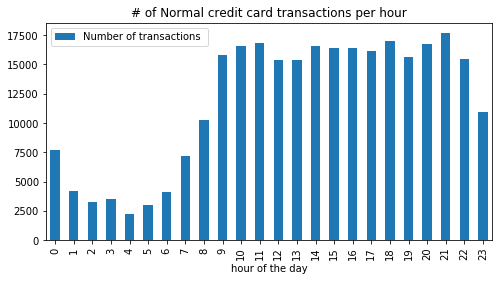

In [20]:
plt.figure(figsize = (8, 4))
validTransactions = timeAnalysisGrouped[0].copy()
validTransactions.name = 'Number of transactions '
validTransactions.plot.bar(title = '# of Normal credit card transactions per hour', legend = True)
plt.show()

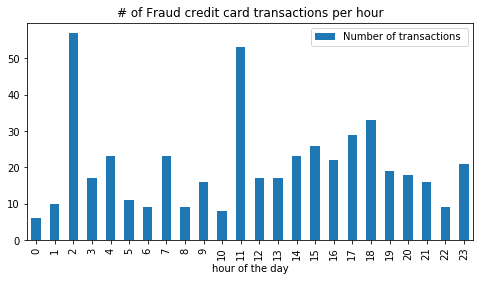

In [21]:
plt.figure(figsize = (8, 4))
validTransactions = timeAnalysisGrouped[1].copy()
validTransactions.name = 'Number of transactions '
validTransactions.plot.bar(title = '# of Fraud credit card transactions per hour', legend = True)
plt.show()

In [22]:
#def roc
def roc_evaluation(r,x_train,x_val,y_train,y_val):
    plt.figure()
    fpr,tpr,_=roc_curve(y_train,r.predict_proba(x_train)[:,1])
    plt.plot(fpr,tpr,label="train_roc_curve")
    fpr,tpr,_=roc_curve(y_val,r.predict_proba(x_val)[:,1])
    plt.plot(fpr,tpr,label="validation_roc_curve")
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC_CURVE")
    print("roc_auc score of train set is {}".format(roc_auc_score(y_train,r.predict_proba(x_train)[:,1])))
    print("roc_auc score of validation set is {}".format(roc_auc_score(y_val,r.predict_proba(x_val)[:,1])))

In [23]:
sample_weight_pos=len(y_train)/y_train.sum()
sample_weight_pos

574.2043010752689

## XGB WITH GRID SEARCH

In [24]:
r1=xgb.XGBClassifier(n_estimators=10000,max_depth=6,learning_rate=0.01,sample_weight_pos=sample_weight_pos,
                     colsample_bytree=0.5,colsample_bylevel=0.5,gamma=1)

In [25]:
r1.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_val,y_val)],eval_metric="auc",early_stopping_rounds=5)

[11:17:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-auc:0.79899	validation_1-auc:0.78373
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.92268	validation_1-auc:0.85746
[2]	validation_0-auc:0.92975	validation_1-auc:0.87433
[3]	validation_0-auc:0.92976	validation_1-auc:0.87432
[4]	validation_0-auc:0.92976	validation_1-auc:0.87432
[5]	validation_0-auc:0.92976	validation_1-auc:0.87432
[6]	validation_0-auc:0.92976	validation_1-auc:0.87433
[7]	validation_0-auc:0.92976	validation_1-auc:0.87434
[8]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, sample_weight_pos=574.2043010752689,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

<Figure size 504x504 with 0 Axes>

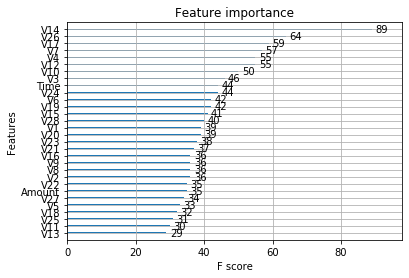

In [26]:
# feature importance from xgboost
plt.figure(figsize=(7,7))
r=xgb.XGBClassifier().fit(x_train,y_train)
xgb.plot_importance(r)

In [27]:
r1=xgb.XGBClassifier(sample_weight_pos=sample_weight_pos,colsample_bytree=0.5,colsample_bylevel=0.5)
params={"n_estimators":[100,200,300,400],"learning_rate":[0.01,0.05,0.1,0.2],"max_depth":[2,4,6]}
gs1=GridSearchCV(r1,param_grid=params,cv=3,scoring="roc_auc",verbose=10000)
gs1.fit(x_train,y_train)
gs1.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[11:19:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.01, max_depth=2, n_estimators=100, score=0.954, total=  12.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=100 ...............
[11:19:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.



[11:25:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.01, max_depth=4, n_estimators=100, score=0.928, total=  21.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  6.4min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=4, n_estimators=100 ...............
[11:25:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if

[CV]  learning_rate=0.01, max_depth=6, n_estimators=100, score=0.938, total=  12.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 14.1min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=200 ...............
[11:33:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.01, max_depth=6, n_estimators=200, score=0.958, total=  24.6s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 14.5min remaining:    0.0s
[CV] learning_rate=0.01, max_depth=6, n_estimators=200 ...............
[11:33:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos }

[11:39:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.05, max_depth=2, n_estimators=200, score=0.974, total=  12.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed: 20.4min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=2, n_estimators=200 ...............
[11:39:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if

[CV]  learning_rate=0.05, max_depth=4, n_estimators=200, score=0.969, total=  19.2s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 24.2min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, n_estimators=300 ...............
[11:43:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.05, max_depth=4, n_estimators=300, score=0.985, total=  29.4s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 24.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, n_estimators=300 ...............
[11:43:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos }

[11:49:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.05, max_depth=6, n_estimators=300, score=0.978, total=  39.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed: 30.8min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=6, n_estimators=300 ...............
[11:50:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if

[CV]  learning_rate=0.1, max_depth=2, n_estimators=300, score=0.974, total=  18.9s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 35.7min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=2, n_estimators=400 ................
[11:54:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.1, max_depth=2, n_estimators=400, score=0.984, total=  25.1s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed: 36.1min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=2, n_estimators=400 ................
[11:55:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } m

[11:59:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.1, max_depth=4, n_estimators=400, score=0.973, total=  38.1s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed: 41.0min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=4, n_estimators=400 ................
[12:00:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if 

[CV]  learning_rate=0.1, max_depth=6, n_estimators=400, score=0.971, total=  38.6s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 47.1min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=2, n_estimators=100 ................
[12:06:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.2, max_depth=2, n_estimators=100, score=0.982, total=   6.2s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed: 47.2min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=2, n_estimators=100 ................
[12:06:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } m

[12:09:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.2, max_depth=4, n_estimators=100, score=0.966, total=   9.7s
[Parallel(n_jobs=1)]: Done 122 out of 122 | elapsed: 50.4min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=4, n_estimators=100 ................
[12:09:41] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if 

[CV]  learning_rate=0.2, max_depth=6, n_estimators=100, score=0.977, total=  11.8s
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 54.8min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=6, n_estimators=200 ................
[12:14:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  learning_rate=0.2, max_depth=6, n_estimators=200, score=0.985, total=  20.0s
[Parallel(n_jobs=1)]: Done 136 out of 136 | elapsed: 55.2min remaining:    0.0s
[CV] learning_rate=0.2, max_depth=6, n_estimators=200 ................
[12:14:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } m

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}

In [28]:

r1=xgb.XGBClassifier(n_estimators=200,max_depth=6,learning_rate=0.05,sample_weight_pos=sample_weight_pos,
                     colsample_bytree=0.5,colsample_bylevel=0.5).fit(x_train,y_train)

[16:36:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sample_weight_pos } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




train data confusion matrix:

[[159924      0]
 [    25    254]]
test data confusion matrix:

[[71072     5]
 [   23   102]]
ROC EVALUATION ON TRAIN DATA:

---------------------------------------------------------------------------
roc_auc score of train set is 0.9999754587730247
roc_auc score of validation set is 0.9709838708577314


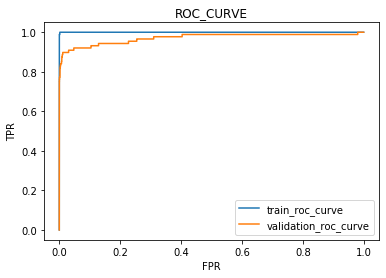

In [29]:
print('train data confusion matrix:\n')
print(confusion_matrix(y_train,r1.predict(x_train)))#train data
print('test data confusion matrix:\n')
print(confusion_matrix(y_test,r1.predict(x_test)))#test data
print('ROC EVALUATION ON TRAIN DATA:\n')
print('---------------------------------------------------------------------------')
roc_evaluation(r1,x_train,x_val,y_train,y_val)

## DECISION TREE, RANDOM FOREST & GRADIENT BOOST WITH GRID SEARCH

In [30]:
def train_classifier(classifier, sample_size, x_train, y_train, x_test, y_test): 
    '''
    inputs:
       - classifier: classifier to be trained and predicted on
       - sample_size: sample size of training set
       - x_train=feature trainings set
       - y_train: label training set
       - X_test: features testing set
       - y_test: labael testing set
    '''
    
    results = {}
    
    # Fit the clasifier to the training data using slicing with 'sample_size'
   
    classifier.fit(x_train[:sample_size],y_train[:sample_size])
    
    
    #  predictions on the test set and training set,
  
    predictions_test = classifier.predict(x_test)
    predictions_train =classifier.predict(x_train)
            
    #accuracy on training samples
    results['auprc_train'] = average_precision_score(y_train, predictions_train)
        
    # accuracy on test set
    results['auprc_test'] = average_precision_score(y_test, predictions_test)
    
    #  F-score training set
    results['f_train'] = fbeta_score( y_train, predictions_train, beta=5)
        
    # F-score on test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=5)
    
    #  accuracy on training samples
    results['auroc_train'] = roc_auc_score(y_train, predictions_train)
        
    # accuracy on test set
    results['auroc_test'] = roc_auc_score(y_test, predictions_test)
       
    #PRINT THE RESULT
    print ("{} trained on {} samples.".format(classifier.__class__.__name__, sample_size))
    print(results)

In [31]:
clf_A = DecisionTreeClassifier(random_state=40)
clf_B = GradientBoostingClassifier()
clf_C=  RandomForestClassifier()  

# Collect results on the classifier
for clf in [clf_A, clf_B,clf_C]:
    samples = len(x_train)
        
    clf_name = clf.__class__.__name__
    
    for i, samples in enumerate([samples]):
        train_classifier(clf, samples, x_train, y_train, x_test, y_test)
        print("-------------------------------------------------------------------------------------------------------------------")

DecisionTreeClassifier trained on 160203 samples.
{'auprc_train': 1.0, 'auprc_test': 0.5666997368987762, 'f_train': 1.0, 'f_test': 0.7297964219617519, 'auroc_train': 1.0, 'auroc_test': 0.8638170997650436}
-------------------------------------------------------------------------------------------------------------------
GradientBoostingClassifier trained on 160203 samples.
{'auprc_train': 0.17008921491233725, 'auprc_test': 0.1439077758285646, 'f_train': 0.23562730104786178, 'f_test': 0.22972546544651315, 'auroc_train': 0.6146234313449426, 'auroc_test': 0.6118874460092575}
-------------------------------------------------------------------------------------------------------------------
RandomForestClassifier trained on 160203 samples.
{'auprc_train': 1.0, 'auprc_test': 0.7639193549093688, 'f_train': 1.0, 'f_test': 0.8200371057513915, 'auroc_train': 1.0, 'auroc_test': 0.90795075762905}
-------------------------------------------------------------------------------------------------------

In [32]:
#Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

#parameters for tuning

parameters = {
              'max_features': [None, 'sqrt', 'log2'],
              'max_depth':[5,8,15,None],
              'min_samples_split':[5,10,20],
              }

# grid search using roc_auc score
gs2 = GridSearchCV(clf, parameters, scoring="roc_auc",verbose=1000)

# find the best parameter
grid_fit = gs2.fit(x_train, y_train)

# obtain the estimator
best_clf = grid_fit.best_estimator_

#predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = best_clf.predict(x_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=5, max_features=None, min_samples_split=5 .............
[CV]  max_depth=5, max_features=None, min_samples_split=5, score=0.830, total=   5.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s
[CV] max_depth=5, max_features=None, min_samples_split=5 .............
[CV]  max_depth=5, max_features=None, min_samples_split=5, score=0.946, total=   5.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s
[CV] max_depth=5, max_features=None, min_samples_split=5 .............
[CV]  max_depth=5, max_features=None, min_samples_split=5, score=0.928, total=   4.5s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s remaining:    0.0s
[CV] max_depth=5, max_features=None, min_samples_split=5 .............
[CV]  max_depth=5, max_features=None, min_samples_split=5, score=0.891, tot

[CV]  max_depth=5, max_features=log2, min_samples_split=5, score=0.836, total=   0.9s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.1min remaining:    0.0s
[CV] max_depth=5, max_features=log2, min_samples_split=10 ............
[CV]  max_depth=5, max_features=log2, min_samples_split=10, score=0.852, total=   0.8s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.1min remaining:    0.0s
[CV] max_depth=5, max_features=log2, min_samples_split=10 ............
[CV]  max_depth=5, max_features=log2, min_samples_split=10, score=0.855, total=   0.9s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=5, max_features=log2, min_samples_split=10 ............
[CV]  max_depth=5, max_features=log2, min_samples_split=10, score=0.840, total=   0.7s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:  2.2min remaining:    0.0s
[CV] max_depth=5, max_features=log2, min_samples_split=10 ............
[CV]  max_depth=5, max_features=log2, min_samples

[CV]  max_depth=8, max_features=sqrt, min_samples_split=10, score=0.866, total=   1.5s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=20 ............
[CV]  max_depth=8, max_features=sqrt, min_samples_split=20, score=0.804, total=   1.5s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:  4.4min remaining:    0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=20 ............
[CV]  max_depth=8, max_features=sqrt, min_samples_split=20, score=0.916, total=   1.4s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  4.5min remaining:    0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=20 ............
[CV]  max_depth=8, max_features=sqrt, min_samples_split=20, score=0.867, total=   1.6s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:  4.5min remaining:    0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=20 ............
[CV]  max_depth=8, max_features=sqrt, min_sample

[CV]  max_depth=15, max_features=None, min_samples_split=20, score=0.909, total=  15.4s
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=15, max_features=sqrt, min_samples_split=5 ............
[CV]  max_depth=15, max_features=sqrt, min_samples_split=5, score=0.808, total=   2.4s
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:  8.5min remaining:    0.0s
[CV] max_depth=15, max_features=sqrt, min_samples_split=5 ............
[CV]  max_depth=15, max_features=sqrt, min_samples_split=5, score=0.911, total=   2.7s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=15, max_features=sqrt, min_samples_split=5 ............
[CV]  max_depth=15, max_features=sqrt, min_samples_split=5, score=0.900, total=   2.4s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  8.6min remaining:    0.0s
[CV] max_depth=15, max_features=sqrt, min_samples_split=5 ............
[CV]  max_depth=15, max_features=sqrt, min_samp

[CV]  max_depth=None, max_features=None, min_samples_split=5, score=0.884, total=  24.9s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 11.5min remaining:    0.0s
[CV] max_depth=None, max_features=None, min_samples_split=10 .........
[CV]  max_depth=None, max_features=None, min_samples_split=10, score=0.875, total=  13.4s
[Parallel(n_jobs=1)]: Done 141 out of 141 | elapsed: 11.7min remaining:    0.0s
[CV] max_depth=None, max_features=None, min_samples_split=10 .........
[CV]  max_depth=None, max_features=None, min_samples_split=10, score=0.946, total=  15.9s
[Parallel(n_jobs=1)]: Done 142 out of 142 | elapsed: 12.0min remaining:    0.0s
[CV] max_depth=None, max_features=None, min_samples_split=10 .........
[CV]  max_depth=None, max_features=None, min_samples_split=10, score=0.928, total=  17.0s
[Parallel(n_jobs=1)]: Done 143 out of 143 | elapsed: 12.3min remaining:    0.0s
[CV] max_depth=None, max_features=None, min_samples_split=10 .........
[CV]  max_depth=None, max_features=No

[CV]  max_depth=None, max_features=log2, min_samples_split=10, score=0.866, total=   6.3s
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed: 15.9min remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_split=20 .........
[CV]  max_depth=None, max_features=log2, min_samples_split=20, score=0.857, total=   5.7s
[Parallel(n_jobs=1)]: Done 176 out of 176 | elapsed: 16.0min remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_split=20 .........
[CV]  max_depth=None, max_features=log2, min_samples_split=20, score=0.937, total=   3.8s
[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed: 16.1min remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_split=20 .........
[CV]  max_depth=None, max_features=log2, min_samples_split=20, score=0.866, total=   3.3s
[Parallel(n_jobs=1)]: Done 178 out of 178 | elapsed: 16.1min remaining:    0.0s
[CV] max_depth=None, max_features=log2, min_samples_split=20 .........
[CV]  max_depth=None, max_features=l

Unoptimized model
------
AUPRC on testing data: 0.5591
AUROC on testing data: 0.8598
F-score on testing data: 0.7220

Optimized Model
------
Final AUPRC on the testing data: 0.6050
Final AUROC the testing data: 0.8679
Final F-score on the testing data: 0.7390
[[71057    20]
 [   33    92]]
Area Under ROC Curve:  0.9463069628712523


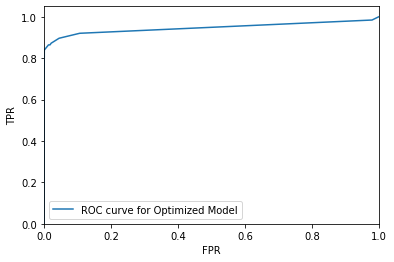

In [33]:
# score before optimization 
print ("Unoptimized model\n------")
print ("AUPRC on testing data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the testing data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))
print(confusion_matrix(y_test,best_predictions))

probas_ = best_clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve: ",area)

#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [34]:
clf = RandomForestClassifier(random_state=42)

# parameters to tune

parameters = {
              'max_features': [0.5,0.75],
              'max_depth':[8,12,15],
              "n_estimators":[100,200,300,400]
              }


# grid search using roc score
gs2 = GridSearchCV(clf, parameters, scoring="roc_auc",cv=3,verbose=1000)

# fit grid search
grid_fit = gs2.fit(x_train, y_train)

# best estimator
best_clf = grid_fit.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.987, total= 6.1min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.972, total= 6.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=100 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=100, score=0.971, total= 6.5min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.8min remaining:    0.0s
[CV] max_depth=8, max_features=0.5, n_estimators=200 .................
[CV]  max_depth=8, max_features=0.5, n_estimators=200, score=0.986, total=11.7min
[Paral

[CV]  max_depth=12, max_features=0.5, n_estimators=400, score=0.971, total=47.2min
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 813.1min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.980, total=18.3min
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 831.4min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.960, total=18.5min
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 849.8min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=100 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=100, score=0.968, total=18.2min
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 868.1min remaining:    0.0s
[CV] max_depth=12, max_features=0.75, n_estimators=200 ...............
[CV]  max_depth=12, max_features=0.75, n_estimators=200, 

[CV]  max_depth=15, max_features=0.75, n_estimators=400, score=0.966, total=85.9min
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed: 2238.6min remaining:    0.0s
[CV] max_depth=15, max_features=0.75, n_estimators=400 ...............
[CV]  max_depth=15, max_features=0.75, n_estimators=400, score=0.966, total=72.7min
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 2311.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 2311.3min finished


Unoptimized model
------
AUPRC on testing data: 0.7463
AUROC on testing data: 0.8920
F-score on testing data: 0.7893

Optimized Model
------
Final AUPRC on the testing data: 0.7639
Final AUROC the testing data: 0.9080
Final F-score on the testing data: 0.8200
[[71070     7]
 [   23   102]]
Area Under ROC Curve:  0.9708451960549827
{'max_depth': 8, 'max_features': 0.5, 'n_estimators': 100}


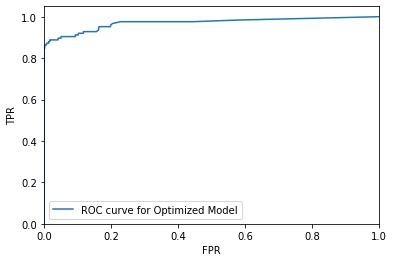

In [35]:
# predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = best_clf.predict(x_test)

# score before optimization
print ("Unoptimized model\n------")
print ("AUPRC on testing data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the testing data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))
print(confusion_matrix(y_test,best_predictions))

probas_ = best_clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve: ",area)
print(gs2.best_params_)

#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

In [36]:
#Initialize the classifier
clf = GradientBoostingClassifier(random_state=42)

#parameters to tune
parameters = {
              'max_features': [0.5,0.75],
              'max_depth':[3,4,6],
              'learning_rate':[0.05,0.1,0.5],
              'n_estimators':[100,200,400],
              }

# grid search using roc score
gs2 = GridSearchCV(clf, parameters, scoring="roc_auc",cv=3,verbose=1000)

# fit grid search
grid_fit = gs2.fit(x_train, y_train)

# best estimator
best_clf = grid_fit.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100, score=0.774, total= 4.6min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100, score=0.833, total= 4.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.1min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100 
[CV]  learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=100, score=0.865, total= 4.5min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.6min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=3, max_features=0.5, n_estimators=200 
[CV]  learning_

[CV]  learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=200, score=0.908, total=18.0min
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 413.8min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=200 
[CV]  learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=200, score=0.915, total=17.7min
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed: 431.5min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=400 
[CV]  learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=400, score=0.972, total=34.5min
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed: 466.1min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=400 
[CV]  learning_rate=0.05, max_depth=4, max_features=0.75, n_estimators=400, score=0.918, total=34.2min
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 500.3min remaining:    0.0s
[CV] learning_rate=0.05, max_depth=4, m

[CV]  learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=100, score=0.860, total= 3.6min
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 888.7min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=100, score=0.855, total= 3.3min
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 892.0min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=100 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=100, score=0.817, total= 2.8min
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed: 894.9min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=200 
[CV]  learning_rate=0.1, max_depth=3, max_features=0.75, n_estimators=200, score=0.860, total= 5.5min
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed: 900.4min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=3, max_featu

[CV]  learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=200, score=0.913, total= 7.0min
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 1479.0min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400, score=0.935, total=14.2min
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed: 1493.2min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400, score=0.959, total=18.3min
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed: 1511.4min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=0.5, n_estimators=400, score=0.913, total=23.1min
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed: 1534.6min remaining:    0.0s
[CV] learning_rate=0.1, max_depth=6, max_features

[CV]  learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=100, score=0.404, total= 2.4min
[Parallel(n_jobs=1)]: Done 128 out of 128 | elapsed: 1715.0min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=100 
[CV]  learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=100, score=0.461, total= 2.5min
[Parallel(n_jobs=1)]: Done 129 out of 129 | elapsed: 1717.5min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=200, score=0.812, total= 4.6min
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed: 1722.2min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=200 
[CV]  learning_rate=0.5, max_depth=4, max_features=0.5, n_estimators=200, score=0.404, total= 4.5min
[Parallel(n_jobs=1)]: Done 131 out of 131 | elapsed: 1726.7min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=4, max_features

[CV]  learning_rate=0.5, max_depth=6, max_features=0.75, n_estimators=400, score=0.846, total=27.3min
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed: 2039.3min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=6, max_features=0.75, n_estimators=400 
[CV]  learning_rate=0.5, max_depth=6, max_features=0.75, n_estimators=400, score=0.327, total=41.4min
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed: 2080.8min remaining:    0.0s
[CV] learning_rate=0.5, max_depth=6, max_features=0.75, n_estimators=400 
[CV]  learning_rate=0.5, max_depth=6, max_features=0.75, n_estimators=400, score=0.856, total=12.7min
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 2093.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed: 2093.5min finished


Unoptimized model
------
AUPRC on testing data: 0.1439
AUROC on testing data: 0.6119
F-score on testing data: 0.2297

Optimized Model
------
Final AUPRC on the testing data: 0.5918
Final AUROC the testing data: 0.8718
Final F-score on the testing data: 0.7458
[[71053    24]
 [   32    93]]
Area Under ROC Curve:  0.9631736848769644
{'learning_rate': 0.05, 'max_depth': 6, 'max_features': 0.75, 'n_estimators': 400}


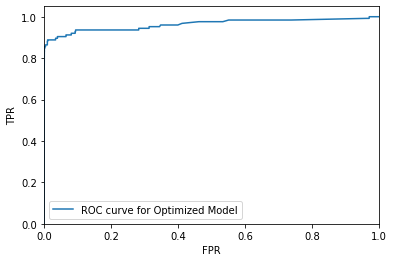

In [37]:
# predictions using the unoptimized model and optimized model
predictions = (clf.fit(x_train, y_train)).predict(x_test)
best_predictions = best_clf.predict(x_test)

# score before optimization
print ("Unoptimized model\n------")
print ("AUPRC on testing data: {:.4f}".format(average_precision_score(y_test, predictions)))
print ("AUROC on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 5)))

#score after optimization
print ("\nOptimized Model\n------")
print ("Final AUPRC on the testing data: {:.4f}".format(average_precision_score(y_test, best_predictions)))
print ("Final AUROC the testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 5)))
print(confusion_matrix(y_test,best_predictions))
      
probas_ = best_clf.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
area = auc(fpr, tpr)
print("Area Under ROC Curve: ",area)
print(gs2.best_params_)

#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Optimized Model')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

## ANN WITH CLASS WEIGHT

In [38]:
scaler=MinMaxScaler()#preparng the data for ANN
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)
x_val=scaler.transform(x_val)
x_train.shape

(160203, 30)

In [39]:
def build_model():
    model = Sequential()
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(15,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=1e-3),loss=tensorflow.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
    return model

In [40]:
epochs=100
batch_size= 2048

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

In [41]:
normal, fraud = np.bincount(df['Class'])
total = normal + fraud
print('Examples:\n    Total: {}\n    Fraud: {} ({:.2f}% of total)\n'.format(total, fraud, 100 * fraud / total))

Examples:
    Total: 284807
    Fraud: 492 (0.17% of total)



In [42]:
weight_for_normal = (1 / normal)*(total)/2.0 
weight_for_fraud = (1 / fraud)*(total)/2.0

class_weight = {0: weight_for_normal, 1: weight_for_fraud}

print('Weight for class 0(Normal Transactions): {:.2f}'.format(weight_for_normal))
print('Weight for class 1(Fraud Transactions): {:.2f}'.format(weight_for_fraud))

Weight for class 0(Normal Transactions): 0.50
Weight for class 1(Fraud Transactions): 289.44


In [43]:
model = build_model()
model.fit(x_train,y_train.values,batch_size=batch_size,epochs=epochs,callbacks = [early_stopping],validation_data=(x_val, y_val.values),\
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 160203 samples, validate on 53402 samples
Epoch 1/100
160203/160203 [==============================] - 5s 31us/sample - loss: 0.6679 - accuracy: 0.6904 - val_loss: 0.6299 - val_accuracy: 0.9989
Epoch 2/100
160203/160203 [==============================] - 1s 9us/sample - loss: 0.6130 - accuracy: 0.7191 - val_loss: 0.5415 - val_accuracy: 0.9728
Epoch 3/100
160203/160203 [==============================] - 1s 7us/sample - loss: 0.5577 - accuracy: 0.7883 - val_loss: 0.4588 - val_accuracy: 0.9973
Epoch 4/100
160203/160203 [==============================] - 1s 6us/sample - loss: 0.5231 - accuracy: 0.8147 - val_loss: 0.4091 - val_accuracy: 0.9965
Epoch 5/100
160203/160203 [==============================] - 1s 6us/sample - loss: 0.4640 - accuracy: 0.8501 - val_loss: 0.3413 - val_accuracy: 0.9994
Epoch 6/100
160203/160203 [==============================] - 1s 5us/sample - loss: 0.4110 - accuracy: 0.8715 - val_loss: 0.2967 - val_accuracy:

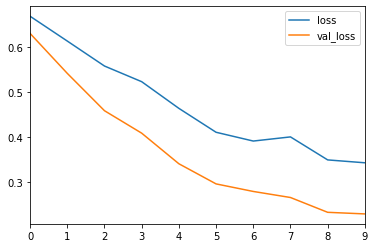

In [44]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

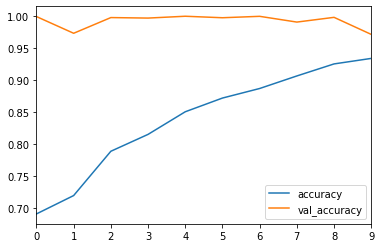

In [45]:
losses[['accuracy','val_accuracy']].plot()

In [46]:
predictions = model.predict_classes(x_test)
print(classification_report(y_test,predictions))
print ("Final AUPRC on the testing data using ANN: {:.4f}".format(average_precision_score(y_test,predictions)))
print ("Final AUROC the testing data using ANN: {:.4f}".format(roc_auc_score(y_test, predictions)))
print ("Final F-score on the testing data using ANN: {:.4f}".format(fbeta_score(y_test,predictions, beta = 5)))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.72      0.78      0.75       120

    accuracy                           1.00     71202
   macro avg       0.86      0.89      0.87     71202
weighted avg       1.00      1.00      1.00     71202

Final AUPRC on the testing data using ANN: 0.5591
Final AUROC the testing data using ANN: 0.8872
Final F-score on the testing data using ANN: 0.7728


Area Under ROC Curve for Test Data:  0.9766938184069103


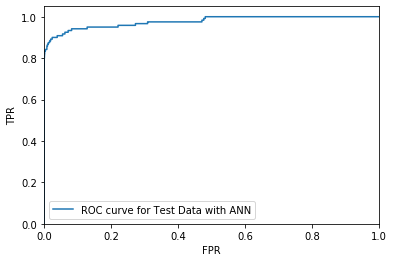

In [47]:
probas_ = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_)
area = auc(fpr, tpr)
print("Area Under ROC Curve for Test Data: ",area)
#plot roc curve
plt.plot(fpr, tpr, label='ROC curve for Test Data with ANN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower left")
plt.show()

Confusion Matrix:

[[71046    36]
 [   27    93]]


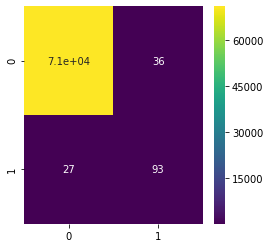

In [48]:
print('Confusion Matrix:\n')
print(confusion_matrix(y_test,predictions))
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test,predictions),cmap='viridis',annot=True)